In [91]:
import pandas as pd

df=pd.read_csv("aqar.csv")

pd.set_option("display.max_columns",None)
df.columns


Index(['id', 'title', 'url', 'price', 'meter_price', 'price_2_payments',
       'price_4_payments', 'price_12_payments', 'rnpl_monthly_price',
       'area_sqm', 'deed_area', 'num_bedrooms', 'num_bathrooms',
       'num_living_rooms', 'num_kitchens', 'num_rooms', 'floor_level',
       'furnished', 'duplex', 'ac', 'lift', 'maid_room', 'driver_room', 'pool',
       'basement', 'backyard', 'playground', 'car_entrance', 'stairs',
       'water_availability', 'electrical_availability',
       'drainage_availability', 'private_roof', 'two_entrances',
       'special_entrance', 'apartment_in_villa', 'street_width', 'direction',
       'city', 'district', 'address', 'latitude', 'longitude', 'category_id',
       'category_ga_listing_type', 'category_ga_property_category',
       'category_is_rent', 'category_name', 'category_en', 'category_plural',
       'category_uri', 'category_path', 'category_keywords',
       'category_description', 'category_index', 'sale_type', 'is_rental',
       'is_

- Use Y-data
- try multi layer preceptron(loss-funtion MSE, opt: adamw, Activation: Leaky ReLU)
- try a Layered ML model(Use three diffrent ml models, they output to the forth)


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'meter_price'}>,
        <Axes: title={'center': 'price_2_payments'}>,
        <Axes: title={'center': 'price_4_payments'}>],
       [<Axes: title={'center': 'price_12_payments'}>,
        <Axes: title={'center': 'rnpl_monthly_price'}>,
        <Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'deed_area'}>,
        <Axes: title={'center': 'num_bedrooms'}>],
       [<Axes: title={'center': 'num_bathrooms'}>,
        <Axes: title={'center': 'num_living_rooms'}>,
        <Axes: title={'center': 'num_kitchens'}>,
        <Axes: title={'center': 'num_rooms'}>,
        <Axes: title={'center': 'floor_level'}>],
       [<Axes: title={'center': 'street_width'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'category_id'}>,
        <Axes: title={'center': 'category_index'}>],
       

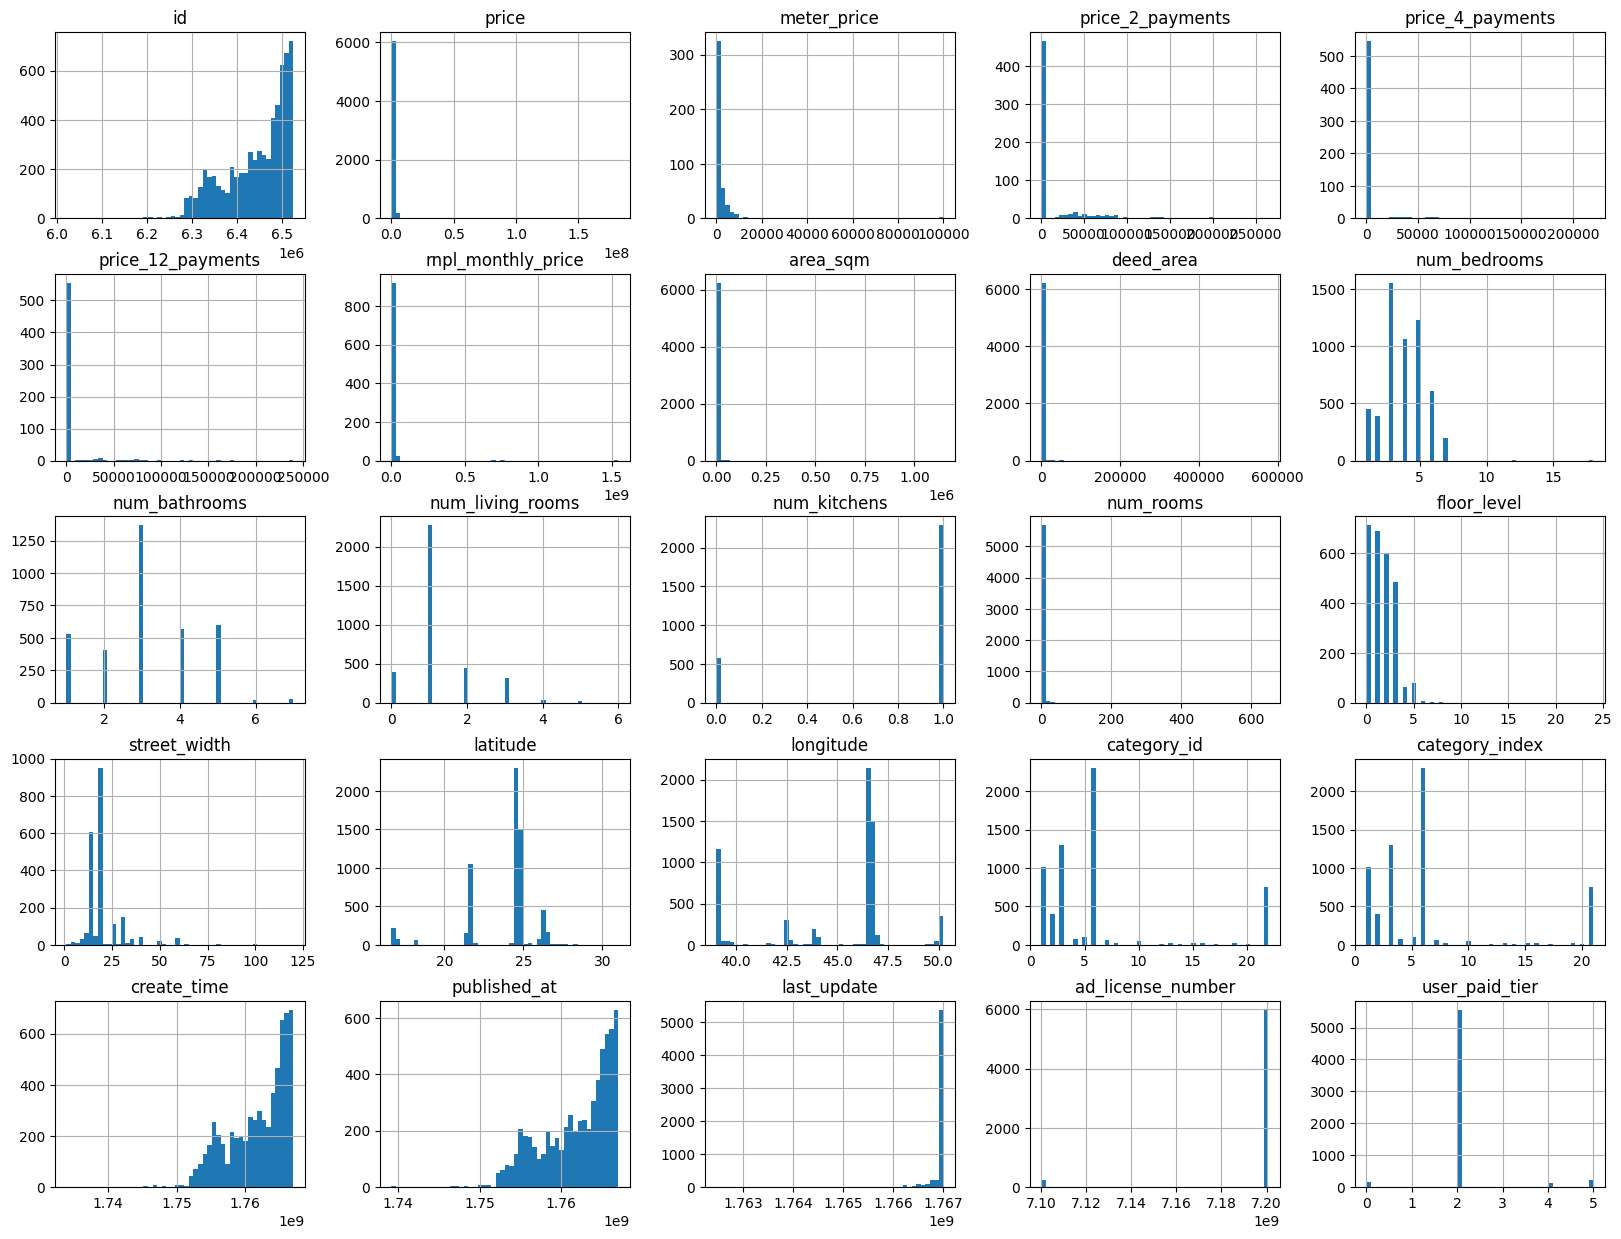

In [92]:
df.hist(bins=50, figsize=(20,15))

In [93]:

num_feature_cols=["area_sqm","num_bedrooms","num_bathrooms"]
cat_feature_cols=["district","city_grouped"]
bool_feature_cols=["lift"]

df : pd.DataFrame = df[(df['is_rental'] == False) & (df['is_daily_rental'] == False) & (df['sale_type'] != 'rent') & (df['sale_type'] !='daily')].copy()
pd.set_option('future.no_silent_downcasting', True)
# drop listings of land without buildings
df : pd.DataFrame = df[df['category_ga_property_category'] != 'land'].copy()
# drop listings of commercial buildings
df : pd.DataFrame = df[(df["category_ga_listing_type"]!= "office") & (df["category_ga_listing_type"]!="store") & (df["category_ga_listing_type"]!="warehouse") & (df["category_ga_listing_type"]!="lounge")].copy()

for bool_col in bool_feature_cols:
    df[bool_col] = df[bool_col].astype(int)

# combine rare cities into 'Other'
city_counts = df['city'].value_counts(normalize=True)
rare_cities = city_counts[city_counts < 0.02].index
df['city_grouped'] = df['city'].apply(lambda x: 'other' if x in rare_cities else x)

target_col=["price"]


df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].head()


,area_sqm,num_bedrooms,num_bathrooms,district,city_grouped,lift,price
0,116.0,4.0,3.0,حي النرجس,الرياض,0,1500000.0
1,700.0,7.0,5.0,حي الملقا,الرياض,1,13500000.0
3,215.0,6.0,NaN,حي دره المنسك,other,0,635000.0
4,169.0,5.0,NaN,حي ابها الجديده,other,0,510000.0
5,208.0,6.0,NaN,حي القريقر,other,0,540000.0


array([[<Axes: title={'center': 'area_sqm'}>,
        <Axes: title={'center': 'num_bedrooms'}>],
       [<Axes: title={'center': 'num_bathrooms'}>,
        <Axes: title={'center': 'lift'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

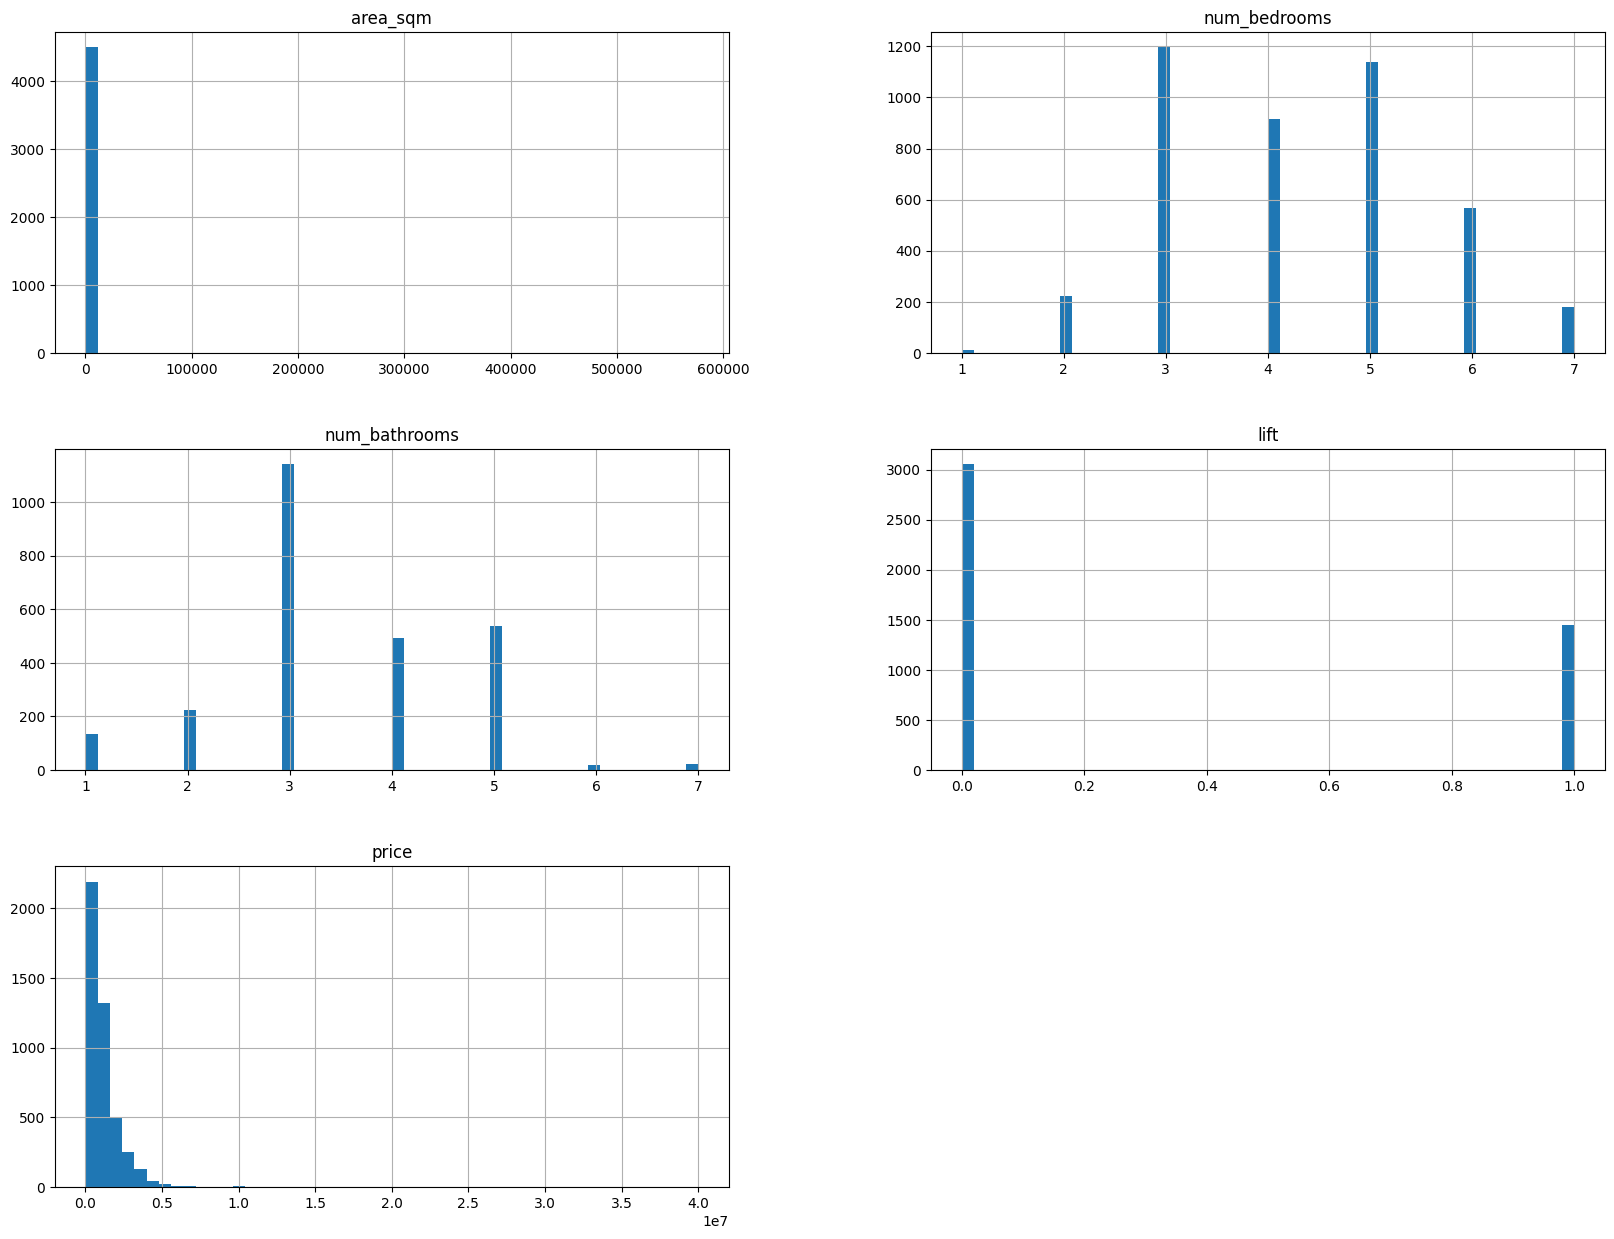

In [94]:
df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].hist(bins=50, figsize=(20,15))


In [95]:
# Profile Data
from ydata_profiling import ProfileReport
profile = ProfileReport(df[num_feature_cols + cat_feature_cols + bool_feature_cols + target_col].copy(), title="Aqar Dataset Profiling Report")
profile.to_file("aqar_data_profiling_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 350.98it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
# Data Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

pipe= ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
])


# Define features and target
X = df[num_feature_cols + cat_feature_cols + bool_feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['city_grouped']
)
X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)
X_train_prepared, X_test_prepared

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 19173 stored elements and shape (3601, 239)>,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 4771 stored elements and shape (901, 239)>)

In [97]:
# Profile the preprocessed data (without OHE for better human readability)
from ydata_profiling import ProfileReport

# Create a profiling-only pipeline (imputation + scaling, but no OHE)
profiling_pipe = ColumnTransformer([
    ("num_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_feature_cols),
    ("cat_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]), cat_feature_cols),
    ("bool_pipeline", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ]), bool_feature_cols)
], remainder='drop')

profiling_pipe.set_output(transform="pandas")

# Transform for profiling
X_train_for_profiling = profiling_pipe.fit_transform(X_train)
X_train_for_profiling['price'] = y_train.values

# Generate profile
profile_preprocessed = ProfileReport(X_train_for_profiling, title="Aqar Preprocessed Data Profiling Report (No OHE)")
profile_preprocessed.to_file("aqar_preprocessed_data_profiling_report.html")
print("Preprocessed data profiling report saved!")
print(f"\nProfiled data shape: {X_train_for_profiling.shape}")
print("Categorical columns preserved for easier interpretation")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 337.45it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Preprocessed data profiling report saved!

Profiled data shape: (3601, 7)
Categorical columns preserved for easier interpretation


array([[<Axes: title={'center': 'num_pipeline__area_sqm'}>,
        <Axes: title={'center': 'num_pipeline__num_bedrooms'}>],
       [<Axes: title={'center': 'num_pipeline__num_bathrooms'}>,
        <Axes: title={'center': 'bool_pipeline__lift'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

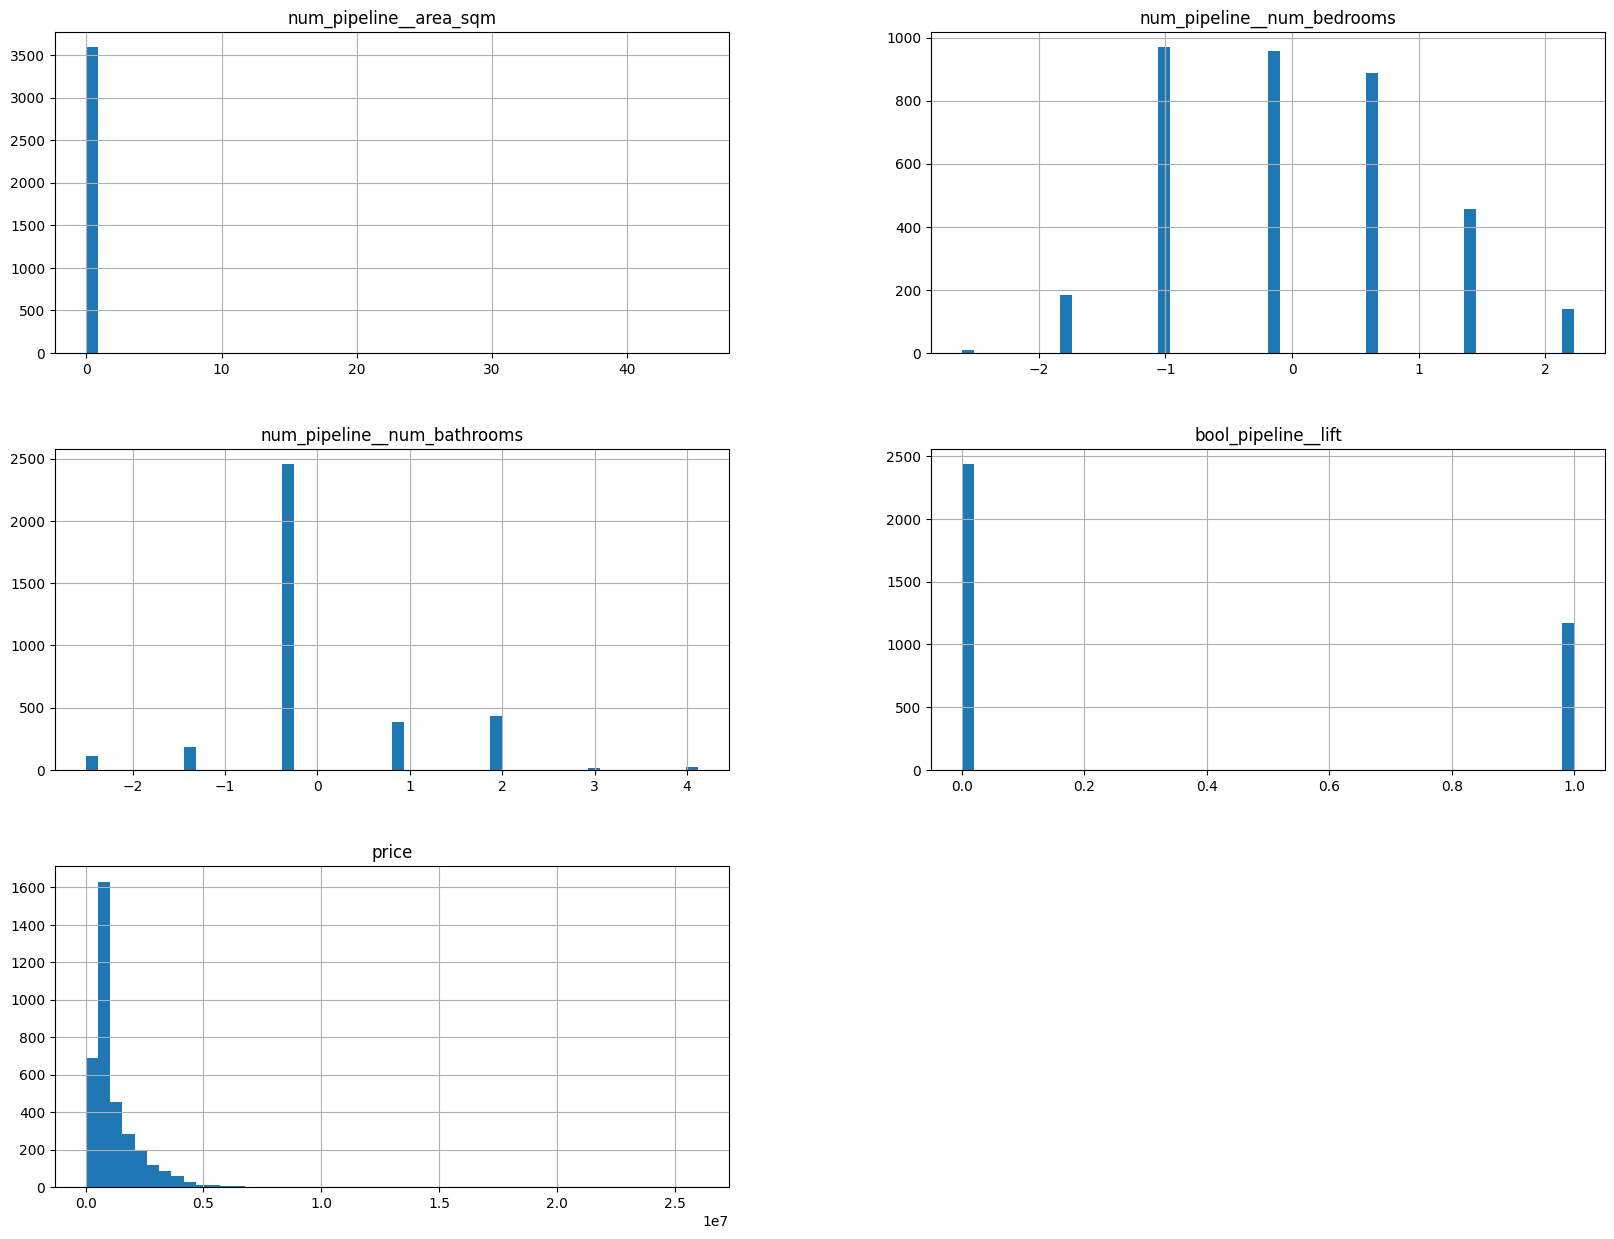

In [98]:
# plot histograms of preprocessed features
X_train_for_profiling.hist(bins=50, figsize=(20,15))

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
model = LinearRegression()

model.fit(X_train_prepared, y_train)


# Make predictions
y_pred = model.predict(X_test_prepared)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 2686069163834.233
R^2 Score: 0.1887889974286312


In [100]:
# grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_prepared, y_train.values.ravel())

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >

In [101]:
model_rf = grid_search.best_estimator_
model_rf.fit(X_train_prepared, y_train.values.ravel())
y_pred_rf = model_rf.predict(X_test_prepared)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R^2 Score: {r2_rf}")

Random Forest Mean Squared Error: 2313386954307.351
Random Forest R^2 Score: 0.30134153810828446


In [102]:
cross_val_scores = cross_val_score(model, X_train_prepared, y_train.values.ravel(), cv=5, scoring='r2')
print(f"Cross-validated R^2 scores: {cross_val_scores}")
print(f"Average Cross-validated R^2 score: {cross_val_scores.mean()}")

cross_val_scores_rf = cross_val_score(model_rf, X_train_prepared, y_train.values.ravel(), cv=5, scoring='r2')
print(f"Random Forest Cross-validated R^2 scores: {cross_val_scores_rf}")
print(f"Random Forest Average Cross-validated R^2 score: {cross_val_scores_rf.mean()}")


Cross-validated R^2 scores: [ 0.23535892 -1.3358275  -0.4576707   0.39914331  0.07218044]
Average Cross-validated R^2 score: -0.21736310544260157
Random Forest Cross-validated R^2 scores: [0.42119464 0.50467158 0.36640078 0.63618454 0.19843874]
Random Forest Average Cross-validated R^2 score: 0.4253780565101334
